In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files

In [ ]:
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [24]:
import pandas as pd
import numpy as np
from keras.layers import Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.utils import np_utils
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# tf.debugging.set_log_device_placement(True)

In [2]:
data = pd.read_json('/Users/yuhanqi/Desktop/Master Thesis/code/data/sample_1000000_2005_2018_cleaned.json')

In [3]:
data['stars_reduce'] = data['stars']-1

In [4]:
data.head(1)

,index,text,stars,cleaned_text,stars_reduce
1105058,2344352,Excellent food and customer service! My mom fo...,5,Excellent food and customer service ! My mom f...,4


In [5]:
dummy_y = np_utils.to_categorical(data.stars_reduce)
dummy_y.shape

(1000000, 5)

In [6]:
X_train, X_test,Y_train, Y_test = train_test_split(data.cleaned_text, dummy_y, test_size=0.2, random_state = 45)

In [31]:
# vocab_size = 100000
# num_words = vocab_size, oov_token='<OOV>'
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#words_to_index is the dictionary mapping words to their respective index.
words_to_index = tokenizer.word_index

In [37]:
maxLen = 300
vocab_len = len(words_to_index)+1
embedding_dim = 64

In [33]:
def conv1d_model(input_shape):

  X_indices = Input(input_shape)

  embeddings = Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=maxLen)(X_indices)

  X = Conv1D(256,3,activation='relu')(embeddings)
  X = Dropout(0.6)(X)
  
  X = Conv1D(128,3,activation='relu')(X)
  X = Dropout(0.6)(X)

  X = GlobalMaxPooling1D()(X)

  X = Dense(128, activation='relu')(X)
  X = Dense(5, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [34]:
model = conv1d_model((maxLen,))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 64)           11020288  
                                                                 
 conv1d_2 (Conv1D)           (None, 298, 256)          49408     
                                                                 
 dropout_2 (Dropout)         (None, 298, 256)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 296, 128)          98432     
                                                                 
 dropout_3 (Dropout)         (None, 296, 128)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0   

In [35]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

print(X_train_indices.shape)

X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

(800000, 300)


In [38]:
adam = tf.keras.optimizers.Adam(learning_rate = 1e-5)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='loss', patience=2)
epochs = 10
history = model.fit(X_train_indices, Y_train, validation_data=(X_test_indices, np.asarray(Y_test)), batch_size=64, epochs=epochs, callbacks=[callback])

Epoch 1/10
12500/12500 [==============================] - 1318s 105ms/step - loss: 1.3325 - accuracy: 0.4427 - val_loss: 1.4509 - val_accuracy: 0.4342
Epoch 2/10
12500/12500 [==============================] - 1256s 101ms/step - loss: 1.0508 - accuracy: 0.5477 - val_loss: 1.1017 - val_accuracy: 0.5793
Epoch 3/10
12500/12500 [==============================] - 1224s 98ms/step - loss: 0.9044 - accuracy: 0.6054 - val_loss: 1.0369 - val_accuracy: 0.6059
Epoch 4/10
12500/12500 [==============================] - 1224s 98ms/step - loss: 0.8601 - accuracy: 0.6231 - val_loss: 1.0052 - val_accuracy: 0.6178
Epoch 5/10
12500/12500 [==============================] - 1227s 98ms/step - loss: 0.8370 - accuracy: 0.6334 - val_loss: 0.9918 - val_accuracy: 0.6237
Epoch 6/10
12500/12500 [==============================] - 1227s 98ms/step - loss: 0.8209 - accuracy: 0.6407 - val_loss: 0.9825 - val_accuracy: 0.6277
Epoch 7/10
12500/12500 [==============================] - 1286s 103ms/step - loss: 0.8087 - accura

In [39]:
model.evaluate(X_test_indices, Y_test)

6250/6250 [==============================] - 103s 16ms/step - loss: 0.9546 - accuracy: 0.6373


[0.9546462297439575, 0.6373050212860107]

Text(0.5, 1.0, 'Accuracy')

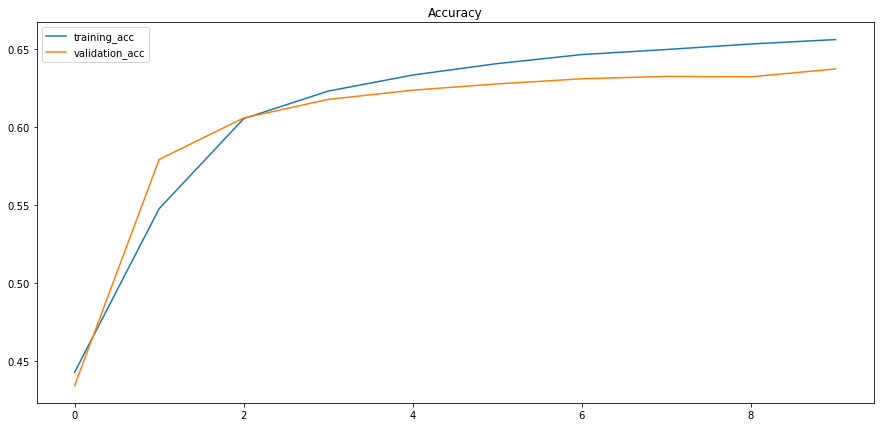

In [40]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

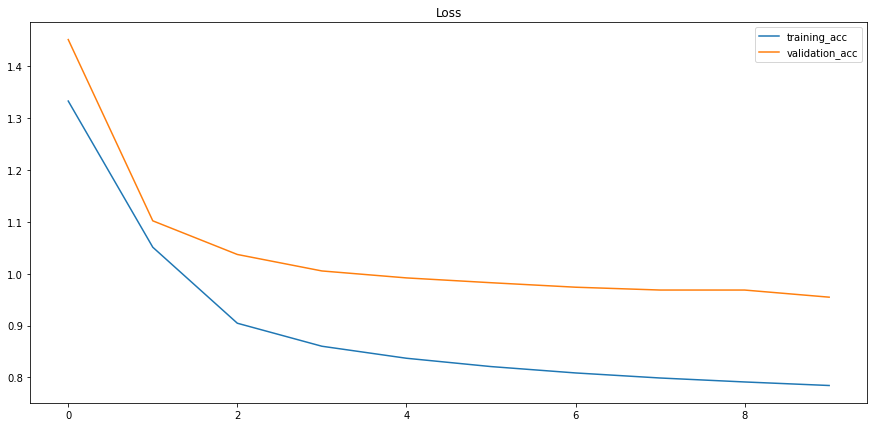

In [41]:
#plot loss
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Loss')

In [42]:
preds = model.predict(X_test_indices)

In [43]:
model.save('/Users/yuhanqi/Desktop/Master Thesis/code/model/keras_cnn_2015_2018_1000000')

INFO:tensorflow:Assets written to: /Users/yuhanqi/Desktop/Master Thesis/code/model/keras_cnn_2015_2018_1000000/assets


In [44]:
loaded_model = keras.models.load_model('/Users/yuhanqi/Desktop/Master Thesis/code/model/keras_cnn_2015_2018_1000000')

In [45]:
# Let's check:
np.testing.assert_allclose(
    model.predict(X_test_indices), loaded_model.predict(X_test_indices)
)

In [46]:
loaded_preds = loaded_model.predict(X_test_indices)

In [47]:
star_pred = np.argmax(loaded_preds, axis=1)+1

In [48]:
confusion_matrix(np.argmax(Y_test, axis=1)+1, star_pred)

array([[14920,  4071,   746,   274,   316],
       [ 4243,  7837,  3643,   742,   218],
       [ 1165,  4706, 11632,  5903,   976],
       [  473,  1046,  7000, 28399, 16020],
       [  572,   444,  1625, 18356, 64673]])

In [49]:
print(classification_report(np.argmax(Y_test, axis=1)+1, star_pred))

              precision    recall  f1-score   support

           1       0.70      0.73      0.72     20327
           2       0.43      0.47      0.45     16683
           3       0.47      0.48      0.47     24382
           4       0.53      0.54      0.53     52938
           5       0.79      0.75      0.77     85670

    accuracy                           0.64    200000
   macro avg       0.58      0.59      0.59    200000
weighted avg       0.64      0.64      0.64    200000

